In [1]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from ramannoodles import spectrafit
from ramannoodles import peakidentify
from ramannoodles import dataprep

In [2]:
cal_example = h5py.File('cal_example.hdf5', 'r')
list(cal_example.keys())

['Carbon Monoxide', 'Hydrogen', 'Methane']

In [3]:
type(list(cal_example.keys()))

list

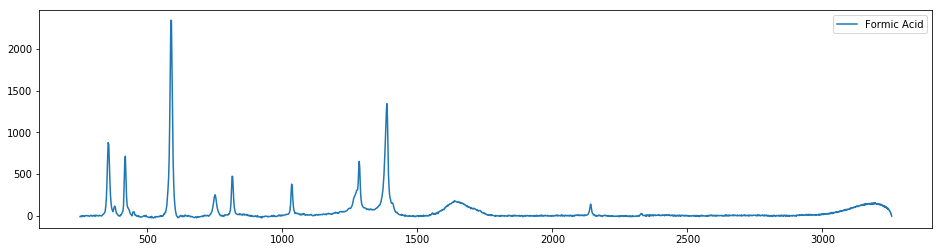

In [4]:
FA_data = pd.read_excel('../development/FormicAcid_3percentconc_400C_5s_00000.xlsx',
                        header=None, names=('x', 'y'))
plt.figure(figsize=(16,4))
plt.plot(FA_data['x'], FA_data['y'], label='Formic Acid')
plt.legend()

In [5]:
# perhaps a new function can be made that wraps these two functions for producing the experimental_data.hdf5
# also perhaps the module should be renamed since it deals with all hdf5 files and not just the calibration file
# data_file = dataprep.new_hdf5('FormicAcid_data')

In [6]:
# type(data_file)

In [7]:
# data_file

In [8]:
# list(data_file.keys())

In [9]:
# dataprep.new_hdf5('dataprep_calibration_test1')


In [10]:
dataprep.view_hdf5('dataprep_calibration_test1.hdf5')

**** dataprep_calibration_test1.hdf5 ****
Hydrogen
|    Peak_1
|    Peak_2
|    Peak_3
|    Peak_4
|    counts
|    wavenumber


In [11]:
# dataprep.add_calibration('dataprep_calibration_test1.hdf5',
#                          '../ramannoodles/tests/test_files/Hydrogen_Baseline_Calibration.xlsx',
#                          label='Hydrogen')

In [12]:
dataprep.view_hdf5('dataprep_calibration_test1.hdf5')

**** dataprep_calibration_test1.hdf5 ****
Hydrogen
|    Peak_1
|    Peak_2
|    Peak_3
|    Peak_4
|    counts
|    wavenumber


In [13]:
H_example = h5py.File('dataprep_calibration_test1.hdf5', 'r')
list(H_example.keys())

['Hydrogen']

In [14]:
list(H_example.values())

[<HDF5 group "/Hydrogen" (6 members)>]

In [15]:
dsetH = H_example['Hydrogen']
dsetH

<HDF5 group "/Hydrogen" (6 members)>

In [16]:
list_of_compounds = list(cal_example.keys())
unknown_x = FA_data['x'].values 
unknown_y = FA_data['y'].values
#peakidentify.peak_assignment(unknown_x, unknown_y, list_of_compounds)

In [17]:
import os
os.remove('dataprep_calibration_test1.hdf5')

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'dataprep_calibration_test1.hdf5'

In [ ]:
# peakidentify.compare_unknown_to_known(unknown_peaks, water_peaks, 0.03)

In [ ]:
# peakidentify.peak_position_comparisons(unknown_peaks, known_peaks, list_of_compounds, association_matrix)

In [ ]:
# peakidentify.plotting_peak_assignments(unknown_x, unknown_y, unknown_peaks, unknown_peak_assignments)

In [ ]:
"""This function takes in compounds from a dictionary from shoyu, and, using spectrafit,
identifies peaks found in both the fed-in known spectra, as well as the unknown spectra
to be analyzed. From that identification, it then classifies the peaks in the unknown
spectra based on the fed-in known spectra.
 """
import math
import numpy as np
import matplotlib.pyplot as plt
from ramannoodles import spectrafit


def peak_assignment(unknown_x, unknown_y, known_compound_list,
                    precision=0.03, plot=True):
    """This function is a wrapper function from which all classification of peaks occurs."""

    #Handling errors in inputs.
    if not isinstance(unknown_x, np.ndarray):
        raise TypeError("Passed value of `unknown_x` is not a np.ndarray! Instead, it is: "
                        + str(type(unknown_x)))

    if not isinstance(unknown_y, np.ndarray):
        raise TypeError("Passed value of `unknown_y` is not a np.ndarray! Instead, it is: "
                        + str(type(unknown_y)))

    if not isinstance(known_compound_list, list):
        raise TypeError("Passed value of `known_compound_list` is not a list! Instead, it is: "
                        + str(type(known_compound_list)))

    #Now we need to check the elements within the known_compound_list to make sure they are correct.
    for i, _ in enumerate(known_compound_list):
        if not isinstance(known_compound_list[i], dict):
            raise TypeError("""Passed value within `known_compound_list` is not a dictionary!
            Instead, it is: """ + str(type(known_compound_list[i])))

    if not isinstance(precision, (float, int)):
        raise TypeError("""Passed value of `precision` is not a float or int!
        Instead, it is: """ + str(type(precision)))

    if not isinstance(plot, bool):
        raise TypeError("""Passed value of `plot` is not a Boolean!
        Instead, it is: """ + str(type(plot)))

    #Lets identify the peaks in the unknown spectrum.
    unknown_peaks = spectrafit.data_report(unknown_x, unknown_y)[0]

    #OK, next identify all of the peaks present in the known compound set.
    #For efficiency, we'll also compare them against the unknown in the same for loop.
    known_compound_peaks = []
    assignment_matrix = []

    for i, _ in enumerate(known_compound_list):
        known_compound_peaks.append(
            spectrafit.compound_report(known_compound_list[i])[0])
        print("The peaks that we found for "
              + str(known_compound_list[i]['title']) + " are: ")
        print(known_compound_peaks[i])
        assignment_matrix.append(compare_unknown_to_known(unknown_peaks,
                                                          known_compound_peaks[i],
                                                          precision))

    #Ok, so that generates a full association matrix that contains everything
    #we need to assign peaks.
    #Now, let's go through and actually assign text to peaks.
    unknown_peak_assignments = peak_position_comparisons(unknown_peaks,
                                                         known_compound_peaks,
                                                         known_compound_list,
                                                         assignment_matrix)
    print(unknown_peak_assignments)

    if plot:
        plotting_peak_assignments(unknown_x, unknown_y, unknown_peaks,
                                  unknown_peak_assignments)

    percentages = percentage_of_peaks_found(known_compound_peaks,
                                            assignment_matrix,
                                            known_compound_list)
    print(percentages)


def compare_unknown_to_known(combined_peaks, known_peaks, precision):
    """This function takes in peak positions for the spectrum to be
    analyzed and a single known compound and determines if the peaks
    found in the known compound are present in the unknown spectrum."""

    #Handling errors in inputs.
    if not isinstance(combined_peaks, list):
        raise TypeError("""Passed value of `combined_peaks` is not a list!
        Instead, it is: """ + str(type(combined_peaks)))

    if not isinstance(known_peaks, list):
        raise TypeError("""Passed value of `known_peaks` is not a list!
        Instead, it is: """ + str(type(known_peaks)))

    if not isinstance(precision, (float, int)):
        raise TypeError("""Passed value of `precision` is not a float or int!
        Instead, it is: """ + str(type(precision)))

    assignment_matrix = np.zeros(len(combined_peaks))
    peaks_found = 0
    for i, _ in enumerate(combined_peaks):
        for j, _ in enumerate(known_peaks):
            # instead of If, call peak_1D_score
            if math.isclose(combined_peaks[i], known_peaks[j],
                            rel_tol=precision):
                # Instead of using a 1, just input the score
                # from the score calculator.
                # Bigger is better.
                # Storing only the second component in the list.
                assignment_matrix[i] = 1
                peaks_found += 1
                continue
            else:
                pass
        if peaks_found == len(known_peaks):
            continue
        else:
            pass
    return assignment_matrix


def peak_position_comparisons(unknown_peaks, known_compound_peaks,
                              known_compound_list,
                              association_matrix):
    """This function takes in an association matrix and turns the numbers
    given by said matrix into a text label."""

    #Handling errors in inputs.
    if not isinstance(unknown_peaks, list):
        raise TypeError("""Passed value of `unknown_peaks` is not a list!
        Instead, it is: """ + str(type(unknown_peaks)))

    if not isinstance(known_compound_peaks, list):
        raise TypeError("""Passed value of `known_compound_peaks` is not a list!
        Instead, it is: """ + str(type(known_compound_peaks)))

    if not isinstance(known_compound_list, list):
        raise TypeError("""Passed value of `known_compound_list` is not a list!
        Instead, it is: """ + str(type(known_compound_list)))

    #Now we need to check the elements within the known_compound_list to make sure they are correct.
    for i, _ in enumerate(known_compound_list):
        if not isinstance(known_compound_list[i], dict):
            raise TypeError("""Passed value within `known_compound_list` is not a dictionary!
            Instead, it is: """ + str(type(known_compound_list[i])))

    if not isinstance(association_matrix, list):
        raise TypeError("""Passed value of `association_matrix` is not a float or int!
        Instead, it is: """ + str(type(association_matrix)))

    unknown_peak_assignment = []
    #Step through the unknown peaks to make an assignment for each unknown peak.

    for i, _ in enumerate(unknown_peaks):
        #We might be able to make a small performance improvement if we were to somehow
        #not search the peaks we already had searched, but that seems to not be trivial.
        position_assignment = []
        #We'll need an outer loop that walks through all the different compound positions
        for j, _ in enumerate(known_compound_peaks):
            if association_matrix[j][i] == 1:
                position_assignment.append(known_compound_list[j]['title'])
            else:
                pass
        if position_assignment == []:
            position_assignment.append("Unassigned")
        unknown_peak_assignment.append(position_assignment)

    return unknown_peak_assignment


def percentage_of_peaks_found(known_peaks, association_matrix, list_of_known_compounds):
    """This function takes in a list of classified peaks, and returns a percentage of
    how many of the material's peaks are found in the unknown spectrum.
    This can be used as a metric of confidence."""

    #Handle bad inputs
    if not isinstance(known_peaks, list):
        raise TypeError("""Passed value of `known_peaks` is not a list!
        Instead, it is: """ + str(type(known_peaks)))

    if not isinstance(list_of_known_compounds, list):
        raise TypeError("""Passed value of `list_of_known_compounds` is not a list!
        Instead, it is: """ + str(type(list_of_known_compounds)))

    # Now we need to check the elements within the
    # list_of_known_compounds to make sure they are correct.
    for i, _ in enumerate(list_of_known_compounds):
        if not isinstance(list_of_known_compounds[i], dict):
            raise TypeError("""Passed value within `list_of_known_compounds` is not a dictionary!
            Instead, it is: """ + str(type(list_of_known_compounds[i])))

    if not isinstance(association_matrix, list):
        raise TypeError("""Passed value of `association_matrix` is not a float or int!
        Instead, it is: """ + str(type(association_matrix)))

    percentage_dict = {}
    for i, _ in enumerate(list_of_known_compounds):
        count_number = sum(association_matrix[i])
        percentage_dict[list_of_known_compounds[i]
                        ['title']] = (count_number / len(known_peaks[i])) * 100

    return percentage_dict


def plotting_peak_assignments(unknown_x, unknown_y, unknown_peaks, unknown_peak_assignments):
    """This function plots a set of unknown peaks, and plots the assigned classification given by
    the functions within peakassignment"""

    #Handling errors in inputs.
    if not isinstance(unknown_peaks, list):
        raise TypeError("""Passed value of `unknown_peaks` is not a list!
        Instead, it is: """ + str(type(unknown_peaks)))

    if not isinstance(unknown_x, (list, np.ndarray)):
        raise TypeError("""Passed value of `unknown_x` is not a list or ndarray!
        Instead, it is: """ + str(type(unknown_x)))

    if not isinstance(unknown_y, (list, np.ndarray)):
        raise TypeError(""" Passed value of `unknown_y` is not a list or ndarray!
        Instead, it is: """ + str(type(unknown_y)))

    #Now we need to check the elements within the unknown_peak_assignment
    #to make sure they are correct.
    for i, _ in enumerate(unknown_peak_assignments):
        if not isinstance(unknown_peak_assignments[i], str):
            raise TypeError("""Passed value within `unknown_peak_assignment` is not a string!
            Instead, it is: """ + str(type(unknown_peak_assignments[i])))

    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'b']
    #fig = plt.figure(figsize=(10, 4), dpi=300)
    plt.plot(unknown_x, unknown_y, color='black', label='Unknown Spectrum')
    for i, _ in enumerate(unknown_peaks):
        plt.axvline(x=unknown_peaks[i], color=colors[i],
                    label=unknown_peak_assignments[i],
                    linestyle='--')
    plt.legend(loc=0, framealpha=1)
    plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.ylim(-0.01, 1.5)
    plt.xlim(300, 3800)
    plt.show()


def peak_1d_score(row_i, row_j, scoremax):
    """
    Returns scores with respect to the repricoal of the
    calculated Euclidean distance between peaks
    #√((x1-x2)^2) in 1D
    #√((x1-x2)^2 + (y1-y2)^2) in 2D

    Parameters:
        row_i (list like):  input list
        row_j (list like): input list
        scoremax (float): Euclidean reciprocal score divided by max score; default is 1

    Returns:
        scores (list): Euclidean reciprocal scores
        peaks (tuple): peaks associated with scores
    """
    # Handling errors at the input
    if not isinstance(row_i, (list, np.ndarray)):
        raise TypeError("""Passed value of `row_i` is not a list or ndarray!
        Instead, it is: """ + str(type(row_i)))
    if not isinstance(row_j, (list, np.ndarray)):
        raise TypeError("""Passed value of `row_j` is not a list or ndarray!
        Instead, it is: """ + str(type(row_j)))
    if not isinstance(scoremax, (float, int)):
        raise TypeError("""Passed value of `scoremax` is not a float or int!
        Instead, it is: """ + str(type(scoremax)))
    if scoremax < 0:
        raise ValueError("""Passed value of `scoremax` is not within bounds!""")

    # Initializing the variables
    scores = []
    peaks = []

    for i, _ in enumerate(row_i):
        for j, _ in enumerate(row_j):
            # Calculating distances between peaks
            distance = np.where((row_i[i] - row_j[j] > 50), np.nan,
                                math.sqrt(sum([math.pow(row_i[i] - row_j[j], 2)])))
            # Score for peaks less than 50 units apart
            if 1 / (distance + 1) > .02:
                # Dividing over the given max score
                scores.append(((1 / (distance + 1)) / scoremax))
                # Appends a tuple of the compared peaks
                peaks.append((row_i[i], row_j[j]))
            else:
                pass
    return scores, peaks


def score_max(row_i, row_j, k):
    """
    Returns list of scores sorted with respect to the peaks
    related to its output max score

    Parameters:
        row_i (list like):  input list
        row_j (list like): input list
        k (int): input integer used to sort the scores / kth highest score

    Returns:
        maxscores (list): Euclidean reciprocal score divided by max score
        maxpeaks (tuple): peaks associated with max scores
    """

    # Handling errors at the input
    if not isinstance(row_i, (list, np.ndarray)):
        raise TypeError("""Passed value of `row_i` is not a list or ndarray!
        Instead, it is: """ + str(type(row_i)))
    if not isinstance(row_j, (list, np.ndarray)):
        raise TypeError("""Passed value of `row_j` is not a list or ndarray!
        Instead, it is: """ + str(type(row_j)))
    if not isinstance(k, int):
        raise TypeError("""Passed value of `k` is not an int!
        Instead, it is: """ + str(type(k)))
    if k < 0:
        raise ValueError("""Passed value of `k` is not within bounds!""")
    try:
        scoremax = sorted(set(peak_1d_score(row_i, row_j, 1)[0][:]))[-k]
        maxscores, maxpeaks = peak_1d_score(row_i, row_j, scoremax)

    except Exception as e:
        print("""Function did not receive a scoremax variable. The variable
        scoremax has been reset back to 1.""")

        maxscores, maxpeaks = peak_1d_score(row_i, row_j, scoremax=1)

    return maxscores, maxpeaks


def score_sort(row_i, row_j, k):
    """
    Returns list of scores sorted

    Parameters:
        list_input (list like):  input list
        row (list like): input list
        k (int): input integer used to sort the scores / kth highest score

    Returns:
        sortedscores (list): sorted Euclidean distances
    """
    # Handling errors at the input
    if not isinstance(row_i, (list, np.ndarray)):
        raise TypeError("""Passed value of `row_i` is not a list or ndarray!
        Instead, it is: """ + str(type(row_i)))
    if not isinstance(row_j, (list, np.ndarray)):
        raise TypeError("""Passed value of `row_j` is not a list or ndarray!
        Instead, it is: """ + str(type(row_j)))
    if not isinstance(k, int):
        raise TypeError("""Passed value of `k` is not an int!
        Instead, it is: """ + str(type(k)))
    if k < 0:
        raise ValueError("""Passed value of `k` is not within bounds!""")

    sortedscores = []
    sortedscores.append(score_max(row_i, row_j, k))
    sortedscores.sort()

    return sortedscores


In [ ]:
# Original peakidentify
"""This function takes in compounds from a dictionary from shoyu, and, using spectrafit,
identifies peaks found in both the fed-in known spectra, as well as the unknown spectra
to be analyzed. From that identification, it then classifies the peaks in the unknown
spectra based on the fed-in known spectra.
 """
import math
import numpy as np
import matplotlib.pyplot as plt
from ramannoodles import spectrafit


def peak_assignment(unknown_x, unknown_y, known_compound_list,
                    precision=0.03, plot=True):
    """This function is a wrapper function from which all classification of peaks occurs."""

    #Handling errors in inputs.
    if not isinstance(unknown_x, np.ndarray):
        raise TypeError("Passed value of `unknown_x` is not a np.ndarray! Instead, it is: "
                        + str(type(unknown_x)))

    if not isinstance(unknown_y, np.ndarray):
        raise TypeError("Passed value of `unknown_y` is not a np.ndarray! Instead, it is: "
                        + str(type(unknown_y)))

    if not isinstance(known_compound_list, list):
        raise TypeError("Passed value of `known_compound_list` is not a list! Instead, it is: "
                        + str(type(known_compound_list)))

    #Now we need to check the elements within the known_compound_list to make sure they are correct.
    for i, _ in enumerate(known_compound_list):
        if not isinstance(known_compound_list[i], dict):
            raise TypeError("""Passed value within `known_compound_list` is not a dictionary!
            Instead, it is: """ + str(type(known_compound_list[i])))

    if not isinstance(precision, (float, int)):
        raise TypeError("""Passed value of `precision` is not a float or int!
        Instead, it is: """ + str(type(precision)))

    if not isinstance(plot, bool):
        raise TypeError("""Passed value of `plot` is not a Boolean!
        Instead, it is: """ + str(type(plot)))

    #Lets identify the peaks in the unknown spectrum.
    unknown_peaks = spectrafit.data_report(unknown_x, unknown_y)[0]

    #OK, next identify all of the peaks present in the known compound set.
    #For efficiency, we'll also compare them against the unknown in the same for loop.
    known_compound_peaks = []
    assignment_matrix = []

    for i, _ in enumerate(known_compound_list):
        known_compound_peaks.append(
            spectrafit.compound_report(known_compound_list[i])[0])
        print("The peaks that we found for "
              + str(known_compound_list[i]['title']) + " are: ")
        print(known_compound_peaks[i])
        assignment_matrix.append(compare_unknown_to_known(unknown_peaks,
                                                          known_compound_peaks[i],
                                                          precision))

    #Ok, so that generates a full association matrix that contains everything
    #we need to assign peaks.
    #Now, let's go through and actually assign text to peaks.
    unknown_peak_assignments = peak_position_comparisons(unknown_peaks,
                                                         known_compound_peaks,
                                                         known_compound_list,
                                                         assignment_matrix)
    print(unknown_peak_assignments)

    if plot:
        plotting_peak_assignments(unknown_x, unknown_y, unknown_peaks,
                                  unknown_peak_assignments)

    percentages = percentage_of_peaks_found(known_compound_peaks,
                                            assignment_matrix,
                                            known_compound_list)
    print(percentages)


def compare_unknown_to_known(combined_peaks, known_peaks, precision):
    """This function takes in peak positions for the spectrum to be
    analyzed and a single known compound and determines if the peaks
    found in the known compound are present in the unknown spectrum."""

    #Handling errors in inputs.
    if not isinstance(combined_peaks, list):
        raise TypeError("""Passed value of `combined_peaks` is not a list!
        Instead, it is: """ + str(type(combined_peaks)))

    if not isinstance(known_peaks, list):
        raise TypeError("""Passed value of `known_peaks` is not a list!
        Instead, it is: """ + str(type(known_peaks)))

    if not isinstance(precision, (float, int)):
        raise TypeError("""Passed value of `precision` is not a float or int!
        Instead, it is: """ + str(type(precision)))

    assignment_matrix = np.zeros(len(combined_peaks))
    peaks_found = 0
    for i, _ in enumerate(combined_peaks):
        for j, _ in enumerate(known_peaks):
            # instead of If, call peak_1D_score
            if math.isclose(combined_peaks[i], known_peaks[j],
                            rel_tol=precision):
                # Instead of using a 1, just input the score
                # from the score calculator.
                # Bigger is better.
                # Storing only the second component in the list.
                assignment_matrix[i] = 1
                peaks_found += 1
                continue
            else:
                pass
        if peaks_found == len(known_peaks):
            continue
        else:
            pass
    return assignment_matrix


def peak_position_comparisons(unknown_peaks, known_compound_peaks,
                              known_compound_list,
                              association_matrix):
    """This function takes in an association matrix and turns the numbers
    given by said matrix into a text label."""

    #Handling errors in inputs.
    if not isinstance(unknown_peaks, list):
        raise TypeError("""Passed value of `unknown_peaks` is not a list!
        Instead, it is: """ + str(type(unknown_peaks)))

    if not isinstance(known_compound_peaks, list):
        raise TypeError("""Passed value of `known_compound_peaks` is not a list!
        Instead, it is: """ + str(type(known_compound_peaks)))

    if not isinstance(known_compound_list, list):
        raise TypeError("""Passed value of `known_compound_list` is not a list!
        Instead, it is: """ + str(type(known_compound_list)))

    #Now we need to check the elements within the known_compound_list to make sure they are correct.
    for i, _ in enumerate(known_compound_list):
        if not isinstance(known_compound_list[i], dict):
            raise TypeError("""Passed value within `known_compound_list` is not a dictionary!
            Instead, it is: """ + str(type(known_compound_list[i])))

    if not isinstance(association_matrix, list):
        raise TypeError("""Passed value of `association_matrix` is not a float or int!
        Instead, it is: """ + str(type(association_matrix)))

    unknown_peak_assignment = []
    #Step through the unknown peaks to make an assignment for each unknown peak.

    for i, _ in enumerate(unknown_peaks):
        #We might be able to make a small performance improvement if we were to somehow
        #not search the peaks we already had searched, but that seems to not be trivial.
        position_assignment = []
        #We'll need an outer loop that walks through all the different compound positions
        for j, _ in enumerate(known_compound_peaks):
            if association_matrix[j][i] == 1:
                position_assignment.append(known_compound_list[j]['title'])
            else:
                pass
        if position_assignment == []:
            position_assignment.append("Unassigned")
        unknown_peak_assignment.append(position_assignment)

    return unknown_peak_assignment


def percentage_of_peaks_found(known_peaks, association_matrix, list_of_known_compounds):
    """This function takes in a list of classified peaks, and returns a percentage of
    how many of the material's peaks are found in the unknown spectrum.
    This can be used as a metric of confidence."""

    #Handle bad inputs
    if not isinstance(known_peaks, list):
        raise TypeError("""Passed value of `known_peaks` is not a list!
        Instead, it is: """ + str(type(known_peaks)))

    if not isinstance(list_of_known_compounds, list):
        raise TypeError("""Passed value of `list_of_known_compounds` is not a list!
        Instead, it is: """ + str(type(list_of_known_compounds)))

    # Now we need to check the elements within the
    # list_of_known_compounds to make sure they are correct.
    for i, _ in enumerate(list_of_known_compounds):
        if not isinstance(list_of_known_compounds[i], dict):
            raise TypeError("""Passed value within `list_of_known_compounds` is not a dictionary!
            Instead, it is: """ + str(type(list_of_known_compounds[i])))

    if not isinstance(association_matrix, list):
        raise TypeError("""Passed value of `association_matrix` is not a float or int!
        Instead, it is: """ + str(type(association_matrix)))

    percentage_dict = {}
    for i, _ in enumerate(list_of_known_compounds):
        count_number = sum(association_matrix[i])
        percentage_dict[list_of_known_compounds[i]
                        ['title']] = (count_number / len(known_peaks[i])) * 100

    return percentage_dict


def plotting_peak_assignments(unknown_x, unknown_y, unknown_peaks, unknown_peak_assignments):
    """This function plots a set of unknown peaks, and plots the assigned classification given by
    the functions within peakassignment"""

    #Handling errors in inputs.
    if not isinstance(unknown_peaks, list):
        raise TypeError("""Passed value of `unknown_peaks` is not a list!
        Instead, it is: """ + str(type(unknown_peaks)))

    if not isinstance(unknown_x, (list, np.ndarray)):
        raise TypeError("""Passed value of `unknown_x` is not a list or ndarray!
        Instead, it is: """ + str(type(unknown_x)))

    if not isinstance(unknown_y, (list, np.ndarray)):
        raise TypeError(""" Passed value of `unknown_y` is not a list or ndarray!
        Instead, it is: """ + str(type(unknown_y)))

    #Now we need to check the elements within the unknown_peak_assignment
    #to make sure they are correct.
    for i, _ in enumerate(unknown_peak_assignments):
        if not isinstance(unknown_peak_assignments[i], str):
            raise TypeError("""Passed value within `unknown_peak_assignment` is not a string!
            Instead, it is: """ + str(type(unknown_peak_assignments[i])))

    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'b']
    #fig = plt.figure(figsize=(10, 4), dpi=300)
    plt.plot(unknown_x, unknown_y, color='black', label='Unknown Spectrum')
    for i, _ in enumerate(unknown_peaks):
        plt.axvline(x=unknown_peaks[i], color=colors[i],
                    label=unknown_peak_assignments[i],
                    linestyle='--')
    plt.legend(loc=0, framealpha=1)
    plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.ylim(-0.01, 1.5)
    plt.xlim(300, 3800)
    plt.show()


def peak_1d_score(row_i, row_j, scoremax):
    """
    Returns scores with respect to the repricoal of the
    calculated Euclidean distance between peaks
    #√((x1-x2)^2) in 1D
    #√((x1-x2)^2 + (y1-y2)^2) in 2D

    Parameters:
        row_i (list like):  input list
        row_j (list like): input list
        scoremax (float): Euclidean reciprocal score divided by max score; default is 1

    Returns:
        scores (list): Euclidean reciprocal scores
        peaks (tuple): peaks associated with scores
    """
    # Handling errors at the input
    if not isinstance(row_i, (list, np.ndarray)):
        raise TypeError("""Passed value of `row_i` is not a list or ndarray!
        Instead, it is: """ + str(type(row_i)))
    if not isinstance(row_j, (list, np.ndarray)):
        raise TypeError("""Passed value of `row_j` is not a list or ndarray!
        Instead, it is: """ + str(type(row_j)))
    if not isinstance(scoremax, (float, int)):
        raise TypeError("""Passed value of `scoremax` is not a float or int!
        Instead, it is: """ + str(type(scoremax)))
    if scoremax < 0:
        raise ValueError("""Passed value of `scoremax` is not within bounds!""")

    # Initializing the variables
    scores = []
    peaks = []

    for i, _ in enumerate(row_i):
        for j, _ in enumerate(row_j):
            # Calculating distances between peaks
            distance = np.where((row_i[i] - row_j[j] > 50), np.nan,
                                math.sqrt(sum([math.pow(row_i[i] - row_j[j], 2)])))
            # Score for peaks less than 50 units apart
            if 1 / (distance + 1) > .02:
                # Dividing over the given max score
                scores.append(((1 / (distance + 1)) / scoremax))
                # Appends a tuple of the compared peaks
                peaks.append((row_i[i], row_j[j]))
            else:
                pass
    return scores, peaks


def score_max(row_i, row_j, k):
    """
    Returns list of scores sorted with respect to the peaks
    related to its output max score

    Parameters:
        row_i (list like):  input list
        row_j (list like): input list
        k (int): input integer used to sort the scores / kth highest score

    Returns:
        maxscores (list): Euclidean reciprocal score divided by max score
        maxpeaks (tuple): peaks associated with max scores
    """

    # Handling errors at the input
    if not isinstance(row_i, (list, np.ndarray)):
        raise TypeError("""Passed value of `row_i` is not a list or ndarray!
        Instead, it is: """ + str(type(row_i)))
    if not isinstance(row_j, (list, np.ndarray)):
        raise TypeError("""Passed value of `row_j` is not a list or ndarray!
        Instead, it is: """ + str(type(row_j)))
    if not isinstance(k, int):
        raise TypeError("""Passed value of `k` is not an int!
        Instead, it is: """ + str(type(k)))
    if k < 0:
        raise ValueError("""Passed value of `k` is not within bounds!""")
    try:
        scoremax = sorted(set(peak_1d_score(row_i, row_j, 1)[0][:]))[-k]
        maxscores, maxpeaks = peak_1d_score(row_i, row_j, scoremax)

    except Exception as e:
        print("""Function did not receive a scoremax variable. The variable
        scoremax has been reset back to 1.""")

        maxscores, maxpeaks = peak_1d_score(row_i, row_j, scoremax=1)

    return maxscores, maxpeaks


def score_sort(row_i, row_j, k):
    """
    Returns list of scores sorted

    Parameters:
        list_input (list like):  input list
        row (list like): input list
        k (int): input integer used to sort the scores / kth highest score

    Returns:
        sortedscores (list): sorted Euclidean distances
    """
    # Handling errors at the input
    if not isinstance(row_i, (list, np.ndarray)):
        raise TypeError("""Passed value of `row_i` is not a list or ndarray!
        Instead, it is: """ + str(type(row_i)))
    if not isinstance(row_j, (list, np.ndarray)):
        raise TypeError("""Passed value of `row_j` is not a list or ndarray!
        Instead, it is: """ + str(type(row_j)))
    if not isinstance(k, int):
        raise TypeError("""Passed value of `k` is not an int!
        Instead, it is: """ + str(type(k)))
    if k < 0:
        raise ValueError("""Passed value of `k` is not within bounds!""")

    sortedscores = []
    sortedscores.append(score_max(row_i, row_j, k))
    sortedscores.sort()

    return sortedscores
